# 3. 케라스와 텐서플로우

__감사말__

프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전 이상에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [2]:
tf.config.list_physical_devices('GPU')

[]

**참고**

아래 코드에 대한 자세한 설명은
[케라스와 텐서플로우](https://codingalzi.github.io/dlp2/keras_and_tf.html)를
참고한다.

## 텐서플로우 텐서

케라스 없이 텐서플로우만 이용해서 신경망 모델을 지정하고 훈련시킬 수 있다.
하지만 아래에 언급된 개념, 기능, 도구를 모두 직접 구현해야 한다.

- 가중치, 편향 등을 저장할 텐서 지정
- 순전파 실행(덧셈, 행렬 곱, `relu()` 함수 등 활용)
- 역전파 실행
- 층과 모델
- 손실 함수
- 옵티마이저
- 평가지표
- 훈련 루프

텐서플로우는 두 종류의 텐서 자료형을 지원한다.

- `tf.Tensor` 자료형
    - 상수 텐서
    - 입출력 데이터 등 변하지 않는 값을 다룰 때 사용.
    - 불변 자료형
- `tf.Variable` 자료형
    - 변수 텐서
    - 모델의 가중치, 편향 등 항목의 업데이트가 필요할 때 사용되는 텐서.
    - 가변 자료형

사용법은 기본적으로 넘파이 어레이와 유사하며, GPU 연산과 그레이디언트 자동계산 등
신경망 모델 훈련에 최적화된 기능을 제공한다.


### 상수 텐서

상수 텐서를 다양한 방식으로 생성할 수 있다.
아래 코드는 직접 상수 텐서의 모양과 항목을 지정한다.

In [3]:
x = tf.constant([[1., 2.], [3., 4.]])
print(x)

tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


넘파이 어레이의 경우와 거의 유사하게 다양한 텐서를 생성하는 함수들이 제공된다.
`tf.ones()` 함수는 1로만 이루어진 상수 텐서를 생성한다.

In [4]:
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


반면에 `tf.zeros()` 텐서는 0으로만 이루어진 상수 텐서를 생성한다.

In [5]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


확률적 통계 분포를 따르는 항목으로 구성된 상수 텐서를 생성하는 함수는 딥러닝에서 매우 유용하다.

- `normal()` 함수: 평균값(`mean`)과 표준편차(`stddev`)를 지정하면 해당 정규분포를 따르는 항목들을 이용하여
원하는 모양의 상수 텐서를 생성한다.

In [6]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[ 1.0422782 ]
 [-0.32193935]
 [ 0.7487146 ]], shape=(3, 1), dtype=float32)


- `uniform()` 함수: 지정된 구간 최솟값(`minval`)과 최댓값(`maxval`) 사이에서 균등분포를 따르는 항목들을 이용하여 상수 텐서를 생성한다.

In [7]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.25453353]
 [0.93360615]
 [0.40943944]], shape=(3, 1), dtype=float32)


**상수 텐서의 수정 불가능성**

한 번 생성된 상수 텐서는 수정이 불가능하다.
예를 들어 인덱싱으로 항목을 수정할 수 없다.

```python
>>> x[0, 0] = 1.0
TypeError                                 Traceback (most recent call last)
<ipython-input-7-242a5d4d3c4a> in <module>
----> 1 x[0, 0] = 1.0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment
```

반면에 넘파이 어레이는 수정이 가능하다.

In [8]:
import numpy as np

y = np.ones(shape=(2, 2))

y[0, 0] = 0.0
print(y)

[[0. 1.]
 [1. 1.]]


**텐서 항목의 자료형**

텐서 항목의 자료형은 `EagerTensor` 라는 텐서다.

In [9]:
type(x[0, 0])

tensorflow.python.framework.ops.EagerTensor

### 변수 텐서

`tf.Variaible` 객체는 항목을 수정할 수 있는 가변 텐서이다.
아래 코드는 정규 분포를 이용하여 (3. 1) 모양의 변수 텐서를 생성한다.

In [10]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-1.6007057 ],
       [-0.06321528],
       [-0.46969637]], dtype=float32)>


**변수 텐서 교체**

`assign()` 메서드는 해당 텐서를 통채로 다른 텐서로 대체한다.

In [11]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

단, 대체하는 텐서의 모양(shape)이 기존 텐서의 모양과 동일해야 한다.

```python
>>> v.assign(tf.ones((3, 2)))
ValueError                                Traceback (most recent call last)
<ipython-input-13-e381ab0c94e6> in <module>
----> 1 v.assign(tf.ones((3, 2)))

~\anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py in assign(self, value, use_locking, name, read_value)
    886         else:
    887           tensor_name = " " + str(self.name)
--> 888         raise ValueError(
    889             ("Cannot assign to variable%s due to variable shape %s and value "
    890              "shape %s are incompatible") %

ValueError: Cannot assign to variable Variable:0 due to variable shape (3, 1) and value shape (3, 2) are incompatible
```

**변수 텐서 항목 수정**

변수 텐서의 특정 항목을 수정하려면 인덱싱과 `assign()` 메서드를 함께 사용한다.
이것이 가능한 이유는 텐서의 항목 또한 텐서이기 때문이다.

In [12]:
v[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [13]:
type(v[0, 0])

tensorflow.python.framework.ops.EagerTensor

상수 텐서의 경우처럼 각 항목은 `EagerTensor` 객체이지만 이번엔 항목 변환이 가능하다.
텐서플로우 내부에서 변수 텐서인 경우와 아닌 경우를 구분해서 `assign()` 메서드의 지원여부를
판단하는 것으로 보인다.

In [14]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

* `assign_add()`와 `assign_sub()`

`assign_sub()` 메서드는 `-=` 연산자,
`assign_add()` 메서드는 `+=` 연산자의 기능을 갖는다.
특히 `assign_sub()` 메서드가 경사하강법 적용과정에서 가중치와 편향 텐서를 업데이트할 때 사용된다.

In [15]:
v.assign_sub(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[2.],
       [0.],
       [0.]], dtype=float32)>

## 텐서플로우 활용법 기초

### 그레이디언트 테이프

*경우 1) 하나의 변수에 대한 그레이디언트*

아래 코드는 제곱 함수의 $x = 3$에서의 미분값인 6을 계산한다.

$$
f(x) = x^2 \quad \Longrightarrow \quad \nabla f(x) = \frac{df(x)}{dx} = 2x
$$

In [16]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


*경우 2) 임의의 텐서 연산에 대한 그레이디언트*

In [17]:
x = tf.Variable(tf.random.uniform((2, 2)))

with tf.GradientTape() as tape:
    y = x**2 + 3

grad_of_y_wrt_x = tape.gradient(y, x)

변수 `x`의 모양은 다음과 같다.

$$
x =
\begin{bmatrix}
x_{11} & x_{12} \\
x_{21} & x_{22}
\end{bmatrix}
$$

`y`를 `x`의 함수로 표현하면 다음과 같다.

$$
y = f(x) = x^2 + 3 =
\begin{bmatrix}
x_{11}^2 + 3 & x_{12}^2 + 3 \\
x_{21}^2 + 3 & x_{22}^2 + 3
\end{bmatrix}
$$

텐서 `x`에 대한 그레이디언트는 다음과 같다.

$$
\nabla f(x) =
\begin{bmatrix}
2 x_{11} & 2 x_{12} \\
2 x_{21} & 2 x_{22}
\end{bmatrix}
$$

그레이디언트 계산 결과는 다음과 같다.

In [18]:
grad_of_y_wrt_x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.3317842 , 0.66027117],
       [0.30813575, 0.02825212]], dtype=float32)>

실제로 그레이디언트 계산에 사용된 `x`는 다음과 같으며
앞서 설명한 식으로 그레이디언트가 계산되었음을
쉽게 확인할 수 있다.

In [19]:
x

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.6658921 , 0.33013558],
       [0.15406787, 0.01412606]], dtype=float32)>

*경우 3) 변수들의 리스트에 대한 그레이언트*

In [20]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))

with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b

grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

텐서 `x`와 변수 `W`, `b`의 모양은 다음과 같다.

$$
x =
\begin{bmatrix}
x_{11} & x_{12} \\
x_{21} & x_{22}
\end{bmatrix},
\qquad
W =
\begin{bmatrix}
w_{11} & w_{12} \\
w_{21} & w_{22}
\end{bmatrix},
\qquad
b =
\begin{bmatrix}
b_{1} & b_{2}
\end{bmatrix}
$$

`y`를 `W`와 `b`의 함수로 표현하면 다음과 같다.

$$
y = f(W, b) = x\cdot W + b =
\begin{bmatrix}
x_{11}\cdot w_{11} + x_{12}\cdot w_{21} + b_1 & x_{11}\cdot w_{12} + x_{12}\cdot w_{22} + b_2 \\
x_{21}\cdot w_{11} + x_{22}\cdot w_{21} + b_1 & x_{21}\cdot w_{12} + x_{22}\cdot w_{22} + b_2 \\
\end{bmatrix}
$$

텐서 `x`에 대한 그레이디언트는 다음과 같다.

$$
\nabla f(W, b) =
\begin{bmatrix}
    \begin{bmatrix}
    x_{11} + x_{21} & x_{11} + x_{21} \\
    x_{12} + x_{22} & x_{12} + x_{22}
    \end{bmatrix},
    \begin{bmatrix}
    2 & 2
    \end{bmatrix}    
\end{bmatrix}
$$

그레이디언트 계산 결과는 다음과 같다.

In [21]:
grad_of_y_wrt_W_and_b

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.8950006 , 0.8950006 ],
        [0.40556693, 0.40556693]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]

실제로 그레이디언트 계산에 사용된 `x`는 다음과 같으며
앞서 설명한 식으로 그레이디언트가 계산되었음을
쉽게 확인할 수 있다.

In [22]:
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.269902  , 0.28763115],
       [0.6250986 , 0.11793578]], dtype=float32)>

### 예제: 선형 이진 분류기

케라스를 전혀 사용하지 않으면서 간단한 선형 분류기를 구현하는 과정을 통해
텐서플로우 API의 기본 기능을 살펴 본다.

**1단계: 데이터셋 생성**

`np.random.multivariate.normal()` 함수는 다변량 정규 분포를 이용하여 지정된 크기의 데이터셋을 생성하며,
사용된 인자의 의미는 다음과 같다.

- `mean`: 데이터셋의 축별 평균값
    - 음성 데이터셋
        - `x` 좌표의 평균값 0
        - `y` 좌표의 평균값 3
    - 양성 데이터셋
        - `x` 좌표의 평균값 3
        - `y` 좌표의 평균값 0
- `cov=[[1, 0.5],[0.5, 1]]`: 공분산 지정
    - 0번 특성과 1번 특성의 분포를 1대 0.5 비율로 지정.
    - 따라서 0번 특성의 축(x-축)으로 보다 넓게 분포됨.
- `size=1000`: 생성되는 데이터셋의 크기

In [23]:
import numpy as np

In [24]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 데이터셋을 합쳐서 훈련셋, 즉, 모델의 입력값으로 지정한다.
`np.vstack()` 함수는 여러 개의 데이터셋을 위아래로 쌓는다.
자료형을 `np.float32`로 지정함에 주의하라.
그렇게 하지 않으면 기본 자료형인 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

- `negative_sample`: (1000, 2) 모양의 텐서
- `positive_sample`: (1000, 2) 모양의 텐서
- `inputs = np.vstack(negative_sample, positive_sample)`: (2000, 2) 모양의 텐서
    - `negative_sample` 데이터셋이 0번부터 999번까지 인덱스.
    - `positive_sample` 데이터셋이 1000번부터 1999번까지 인덱스.

In [25]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 레이블은 0, 양성 샘플의 레이블은 1로 지정한다.
레이블 데이터셋 또한 2차원 어레이로 지정됨에 주의하라.
이유는 케라스의 신경망 모델은 하나의 입력 샘플에 대해 여러 종류의 예측값을 계산하도록 설계되어 있기 때문에
여기서처럼 입력 샘플 각각에 대해 양성/음성 여부 하나만 예측하더라도 길이가 1인 벡터로 출력값이 계산된다.
즉, 층에 사용되는 유닛이 하나라 하더라도 스칼라가 아닌 길이가 1인 벡터로 층의 출력값이 계산된다.

- `np.zeros((num_samples_per_class, 1), dtype="float32")`: (1000, 1) 모양의 어레이. 0으로 채워짐.
    0번부터 999번 인덱스까지의 모든 음성 데이터의 타깃은 0임.
- `np.ones((num_samples_per_class, 1), dtype="float32")`: (1000, 1) 모양의 어레이. 1로 채워짐.
    999번부터 1999번 인덱스까지의 모든 양성 데이터의 타깃은 1임.
- `targets`: (2000, 1) 모양의 어레이.

In [26]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: y 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

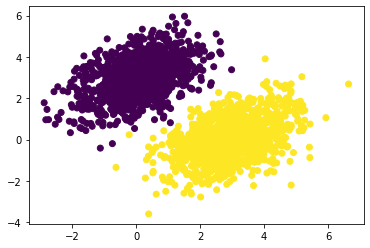

In [27]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**2단계: 선형 회귀 모델 훈련에 필요한 가중치 변수 텐서와 편향 변수 텐서 생성**

선형 분류기 모델의 예측값 계산은 다음과 같이 이뤄진다.

```python
inputs @ W + b
```

- `inputs`: (2000, 2) 모양의 입력 데이터셋 행렬
- `W`: (2, 1) 모양의 가중치 행렬
- `inputs @ W`: (2000, 1) 모양의 행렬
-  `b`: (1,) 모양의 벡터
- `inputs @ W + b`: (2000, 1) 모양의 출력값 행렬. 즉, 2000 개의 입력 데이터 각각에 대해 하나의 값의 계산됨.

위 식을 구현하기 위해 먼저 아핀 변환에 사용될 가중치 행렬과 편향 벡터를 각각
(2000, 2) 모양의 변수 텐서와 (1, ) 모양의 변수 텐서로 선언한다.
`input_dim`과 `output_dim` 은 각각 입력 샘플의 차원고하 출력 샘플의 차원을 가리킨다.

In [28]:
input_dim = 2     # 입력 샘플의 특성이 2개
output_dim = 1    # 하나의 값으로 출력

가중치 행렬은 정규 분포를 이용하여 무작위로, 편향 벡터는 0 벡터로 초기화 한다.

In [29]:
# 가중치: 무작위 초기화
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))

# 편향: 0으로 초기화
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**3단계: 모델 선언(포워드 패스)**

아래 `dense()` 함수는 밀집층(dense layer)에서의 아핀 변환을 담당한다.

In [30]:
def dense(inputs, W, b, activation=None):
    outputs = tf.matmul(inputs, W) + b
    if activation != None:
        return activation(outputs)
    else:
        return outputs

신경망 모델을 훈련할 때 입력값에 대한 예측값을 계산하는 과정인
포워드 패스를 함수로 구현한다.
여기서는 간단한 모델 표현을 위해 하나의 유닛으로 구성된 층 하나로 구성된 모델을 설정한다.
즉, 앞서 언급한 아핀 변환으로 바로 모델의 출력값을 계산하는 모델을 사용한다.
또한 보다 간단한 설명을 위해 활성화 함수는 사용하지 않는다.

In [31]:
def model(inputs):
    outputs = dense(inputs, W, b)
    return outputs

**4단계: 손실 함수 지정**

타깃과 예측값 사이의 평균 제곱 오차를 손실값으로 사용한다.
아래 식에서 $m_b$은 배치 크기를 가리킨다.

$$
\frac{1}{m_b}\sum (y - \hat y)^2
$$

아래 코드에서 `tf.reduce_mean()` 함수는 텐서 항목들의 평균값을 계산한다.

In [32]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**5단계: 훈련 스텝(역전파) 지정**

아래 `training_step()` 함수는
하나의 배치 입력 데이터셋에 대해 역전파 기능을 수행한다.

- 그레이디언트 테이프
    - 모델의 예측값을 이용하여 손실 함수 계산
    - 손실 함수의 그레이디언트 계산 준비
- 가중치 변수 텐서와 편향 변수 텐서에 대한 손실 함수의 그레이디언트 계산
- 가중치 행렬과 편향 벡터 업데이트

In [33]:
learning_rate = 0.1

def training_step(inputs, targets):
    """
    - inputs: 입력 데이터 배치
    - targets: 타깃 배치
    """

    # 손실 함수의 그레이디언트 계산 준비
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)

    # 가중치와 편향에 대한 그레이디언트 계산
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])

    # 가중치 행렬과 편향 벡터 업데이트(경사하강법 적용)
    W.assign_sub(grad_loss_wrt_W * learning_rate) # 가중치 행렬 업데이트
    b.assign_sub(grad_loss_wrt_b * learning_rate) # 편향 업데이트

    return loss

**6단계: 훈련 루프 지정**

반복해서 훈련한 내용을 출력한다.
여기서는 설명을 간단하게 하기 위해 전체 데이터셋을 하나의 배치로 사용하는 훈련을 구현한다.
전체 훈련셋을 총 40번 반복 학습할 때마다 손실값을 출력하도록 한다.

In [34]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.5860
Loss at step 1: 0.2955
Loss at step 2: 0.1368
Loss at step 3: 0.1109
Loss at step 4: 0.1016
Loss at step 5: 0.0949
Loss at step 6: 0.0889
Loss at step 7: 0.0836
Loss at step 8: 0.0786
Loss at step 9: 0.0741
Loss at step 10: 0.0701
Loss at step 11: 0.0663
Loss at step 12: 0.0629
Loss at step 13: 0.0598
Loss at step 14: 0.0569
Loss at step 15: 0.0544
Loss at step 16: 0.0520
Loss at step 17: 0.0498
Loss at step 18: 0.0479
Loss at step 19: 0.0461
Loss at step 20: 0.0444
Loss at step 21: 0.0429
Loss at step 22: 0.0416
Loss at step 23: 0.0403
Loss at step 24: 0.0392
Loss at step 25: 0.0381
Loss at step 26: 0.0372
Loss at step 27: 0.0363
Loss at step 28: 0.0355
Loss at step 29: 0.0348
Loss at step 30: 0.0342
Loss at step 31: 0.0336
Loss at step 32: 0.0330
Loss at step 33: 0.0325
Loss at step 34: 0.0320
Loss at step 35: 0.0316
Loss at step 36: 0.0313
Loss at step 37: 0.0309
Loss at step 38: 0.0306
Loss at step 39: 0.0303


훈련상태를 보면 여전히 개선의 여지가 보인다. 따라서 학습을 좀 더 시켜본다.

In [35]:
for step in range(100):
    loss = training_step(inputs, targets)
    if step % 10 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.0300
Loss at step 10: 0.0284
Loss at step 20: 0.0277
Loss at step 30: 0.0275
Loss at step 40: 0.0274
Loss at step 50: 0.0273
Loss at step 60: 0.0273
Loss at step 70: 0.0273
Loss at step 80: 0.0273
Loss at step 90: 0.0273


**7단계: 결정경계**

In [36]:
predictions = model(inputs)

모델의 예측값이 0.5보다 클 때 양성으로 판정한다.
이유는 샘플들의 레이블이 0 또는 1이기 때문이다.
모델은 훈련과정 중에 음성 샘플은 최대한 0에,
양성 샘플은 최대한 1에 가까운 값으로 예측하여 손실값을 최대한 줄여야 하는데
`training_step()` 함수에서 구현된 경사하강법이 그렇게 유도한다.
따라서 예측값이 0과 1의 중간값인 0.5일 때를 결정경계로 사용한다.

아래 코드는 예측 결과에 따른 산점도로 보여준다.
거의 모든 샘플에 대해 원래의 레이블과 동일한 예측값을 계산함을 알 수 있다.

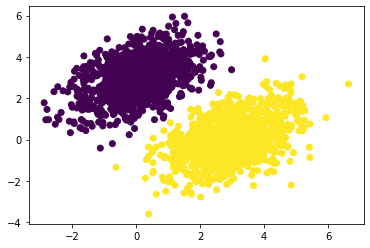

In [37]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

결정경계를 직선으로 그리려면 아래 일차 함수를 이용한다.

```python
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
```

이유는 아래 식으로 계산되는 모델의 예측값이
0.5보다 큰지 여부에 따라 양성/음성이 판단되기 때문이다.

```python
W[0]*x + W[1]*y + b
```

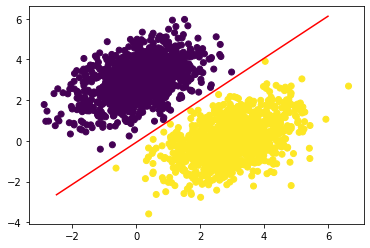

In [38]:
x = np.linspace(-2.5, 6, 150)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]

plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

## 케라스 신경망 모델의 핵심 API

### 층

**`Dense` 클래스 직접 구현하기**

`Dense` 클래스와 유사하게 작동하는 클래스를 직접 정의하려면
상속해야 하는 `keras.layers.Layer` 클래스의 `__call()__` 메서드에 의해 호출되는
`build()` 메서드와 `call()` 메서드를 구현해야 한다.
아래 `SimpleDense` 클래스가 `Dense` 클래스의 기능을 단순화하여 구현한다.

In [39]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]   # 입력 샘플의 특성 수
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

**Example (`SimpleDense` 층의 데이터 변환)**

- 모델 구성: 생성자에 의해 출력 샘플의 특성수와 활성화 함수 지정.
    - 입력 데이터셋 샘플의 특성수는 지정할 필요 없음.

In [40]:
my_dense = SimpleDense(units=512, activation=tf.nn.relu)

- 입력 데이터셋 지정: 입력 샘플 하나의 특성수는 784. 샘플 수는 128 개.

In [41]:
input_tensor = tf.ones(shape=(128, 784))

출력값 생성: `__call__()` 메서드를  실행하면 다음 사항들이 연속적으로 처리된다.

- 가중치 텐서와 와 편향 텐서가 생성되지 않은 경우
    - 가중치 텐서 `W` 생성 및 초기화: `(784, 512)`
    - 편향 텐서 `b` 생성 및 초기화: `(512, )`
- 생성된 가중치와 편향을 이용하여 출력값 계산(아핀 변환 및 활성화 함수 적용)

In [42]:
output_tensor = my_dense(input_tensor)

print(output_tensor.shape)

(128, 512)


### 모델

`Sequential` 모델처럼 작동하는 클래스를 직접 정의한다.

In [43]:
class MySequential(keras.Model):
    def __init__(self, list_layers): # 층들의 리스트 지정
        super().__init__()
        self.list_layers = list_layers

    # 포워드 패스: 층과 층을 연결하는 방식으로 구현
    def call(self, inputs):
        outputs = inputs
        for layer in self.list_layers:
            outputs = layer(outputs)
        return outputs

아래 두 개의 층을 이용하여 모델을 지정하고 다중 클래스 분류 모델에 맞게 모델을 컴파일한다.

In [44]:
layer_1 = SimpleDense(units=512, activation=tf.nn.relu)   # 첫째 밀집층
layer_2 = SimpleDense(units=10, activation=tf.nn.softmax) # 둘째 밀집층

In [45]:
model = MySequential([layer_1, layer_2])

**모델 컴파일**

모델의 훈련을 위해서 먼저 다음 세 가지 설정을 추가로 지정해야 한다.

- 손실 함수: 훈련 중 모델의 성능이 얼마나 나쁜지 측정.
    미분가능한 함수이어야 하며 옵티마이저가 역전파를 통해
    모델의 성능을 향상시키는 방향으로 모델의 가중치를 업데이트할 때
    참고하는 함수임.
- 옵티마이저: 백워드 패스와 역전파를 담당하는 알고리즘
- 평가지표: 훈련과 테스트 과정을 모니터링 할 때 사용되는 모델 평가 지표.
    옵티마이저와 손실함수와는 달리 훈련에 관여하지 않으면서
    모델 성능 평가에 사용됨.

In [46]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### 훈련 루프

모델을 컴파일한 다음에 `fit()` 메서드를 호출하면
모델은 스텝과 에포크 단위로 반복되는 **훈련 루프**<font size='2'>training loop</font>를
지정된 횟수만큼 또는 학습이 충분히 이루어졌다는 평가가 내려질 때까지
반복하는 훈련을 시작한다.

In [47]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [48]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255   # 0과 1사이의 값
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255     # 0과 1사이의 값

**지도 학습 모델 훈련**

In [49]:
training_history = model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2647 - accuracy: 0.9243
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1062 - accuracy: 0.9687
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0698 - accuracy: 0.9791
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0510 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0381 - accuracy: 0.9885


**훈련 결과**

훈련이 종료되면 `fit()` 메서드는 `History` 객체를 반환하며,
`history` 속성에 훈련 과정 중에 측정된 손실값, 평가지표를 에포크 단위로 기억한다.

In [50]:
training_history.history

{'loss': [0.2646557688713074,
  0.10615721344947815,
  0.06981465965509415,
  0.05098618566989899,
  0.03809049725532532],
 'accuracy': [0.9243000149726868,
  0.9686833620071411,
  0.9790999889373779,
  0.9845499992370605,
  0.9884833097457886]}

**검증 데이터 활용**

아래 과정은 훈련셋와 검증셋를 수동으로 구분하는 방법을 보여준다.

- `np.random.permutation()` 함수는 숫자들을 무작위로 섞는다.
    이를 이용하여 훈련세트의 인덱스를 무작위로 섞는다.

In [51]:
indices_permutation = np.random.permutation(len(train_images))

- 무작위로 섞인 인덱스를 이용하여 데이터셋으르 재정렬 한다.

In [52]:
shuffled_inputs = train_images[indices_permutation]
shuffled_targets = train_labels[indices_permutation]

- 재정렬된 데이터셋의 30%를 검증셋로 분류한다.

In [53]:
num_validation_samples = int(0.3 * len(train_images))

val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]

- 나머지는 훈련셋로 지정한다.

In [54]:
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

*훈련 중 모델 검증*

- 훈련셋를 대상으로 하는 훈련과 검증셋를 대상으로 하는 평가를 동시에 진행할 수 있다.

In [55]:
training_history = model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=128,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
329/329 [==============================] - 2s 5ms/step - loss: 0.0289 - accuracy: 0.9914 - val_loss: 0.0291 - val_accuracy: 0.9911
Epoch 2/5
329/329 [==============================] - 2s 5ms/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0346 - val_accuracy: 0.9894
Epoch 3/5
329/329 [==============================] - 2s 5ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.0308 - val_accuracy: 0.9903
Epoch 4/5
329/329 [==============================] - 2s 5ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0422 - val_accuracy: 0.9868
Epoch 5/5
329/329 [==============================] - 2s 5ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0359 - val_accuracy: 0.9893


`History` 객체는 훈련셋 뿐만 아니라 검증셋를 대상으로도 손실값과 평가지표를 기억한다.

In [56]:
training_history.history

{'loss': [0.028907116502523422,
  0.020808285102248192,
  0.016080817207694054,
  0.011315716430544853,
  0.009036778472363949],
 'accuracy': [0.9913809299468994,
  0.9938809275627136,
  0.9953333139419556,
  0.9970476031303406,
  0.9972380995750427],
 'val_loss': [0.029058611020445824,
  0.034578707069158554,
  0.030751166865229607,
  0.04220807924866676,
  0.0358734093606472],
 'val_accuracy': [0.9911110997200012,
  0.9894444346427917,
  0.9903333187103271,
  0.9868333339691162,
  0.9892777800559998]}

*훈련 후 모델 검증*

훈련 후에 테스트셋을 이용하여 평가하려면 `evaluate()` 메서드를 이용한다.

In [57]:
loss_and_metrics = model.evaluate(test_images, test_labels, batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 0.9811


In [58]:
print(loss_and_metrics)

[0.07674925774335861, 0.9811000227928162]


### 예측

훈련된 모델을 활용하는 두 가지 방법이 있다.

**모델 적용**

먼저, `__call__()` 메서드를 활용한다. 즉,
모델을 마치 함수처럼 데이터셋을 인자로 사용하여 호출한다.

In [59]:
predictions = model(test_images)
print(predictions[:5])

tf.Tensor(
[[2.4418665e-11 1.7480213e-15 6.3462902e-09 2.5399342e-05 7.0157032e-17
  1.8367609e-10 4.4069197e-20 9.9997461e-01 3.7994707e-10 3.1813752e-08]
 [4.6918269e-15 1.2111651e-07 9.9999988e-01 6.6467047e-11 2.0108105e-26
  6.2426196e-11 8.9653518e-14 3.3553213e-24 4.3448188e-12 4.3559324e-22]
 [1.2340856e-09 9.9958247e-01 4.5355013e-05 2.0117452e-07 1.1824810e-06
  1.6022017e-07 3.1727890e-07 9.9935554e-05 2.7047962e-04 4.3762757e-08]
 [9.9996889e-01 4.9163662e-17 1.3179718e-07 3.1452674e-10 1.7990340e-10
  3.2809108e-08 7.1560464e-08 3.0626499e-05 2.4037877e-12 2.7862538e-07]
 [8.8742902e-10 2.6191188e-15 1.3556793e-08 1.5351349e-11 9.9991298e-01
  6.0876831e-11 2.8038203e-09 1.7253505e-07 2.1786919e-09 8.6921340e-05]], shape=(5, 10), dtype=float32)


**`predict()` 메서드**

하지만 위 방식은 데이터셋이 매우 크면 적절하지 않을 수 있다.
따라서 `predict()` 메서드를 이용하여 배치를 활용하는 것을 추천한다.

In [60]:
predictions = model.predict(test_images, batch_size=128)
print(predictions[:5])

[[2.4418618e-11 1.7480079e-15 6.3463022e-09 2.5399318e-05 7.0157568e-17
  1.8367680e-10 4.4069533e-20 9.9997461e-01 3.7994924e-10 3.1813691e-08]
 [4.6918091e-15 1.2111617e-07 9.9999988e-01 6.6467047e-11 2.0108182e-26
  6.2426432e-11 8.9653172e-14 3.3553086e-24 4.3448357e-12 4.3559657e-22]
 [1.2340833e-09 9.9958247e-01 4.5355013e-05 2.0117395e-07 1.1824766e-06
  1.6022017e-07 3.1727799e-07 9.9935460e-05 2.7047936e-04 4.3762839e-08]
 [9.9996889e-01 4.9163662e-17 1.3179707e-07 3.1452674e-10 1.7990373e-10
  3.2809108e-08 7.1560464e-08 3.0626441e-05 2.4037877e-12 2.7862458e-07]
 [8.8742730e-10 2.6191089e-15 1.3556793e-08 1.5351378e-11 9.9991298e-01
  6.0876713e-11 2.8038203e-09 1.7253505e-07 2.1786877e-09 8.6921253e-05]]
